In [2]:
import os
if os.name == 'nt':
    !pip install wandb torch==1.8.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html opencv-python torchvision %CD%\.. --quiet
else:
    !pip install wandb torch==1.8.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html opencv-python torchvision $(pwd)/.. --quiet

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

import wandb
import time
import numpy as np
import torchvision
from perceiver_pytorch import Perceiver

In [4]:
# 1. Start a W&B run
wandb.init(project='mnist-perceiver', entity='rosenblatt')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rosenblatt (use `wandb login --relogin` to force relogin)
C:\Users\Ryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


In [5]:
?Perceiver

Init signature:
Perceiver(
    *,
    num_freq_bands,
    depth,
    max_freq,
    freq_base=2,
    input_channels=3,
    input_axis=2,
    num_latents=512,
    latent_dim=512,
    cross_heads=1,
    latent_heads=8,
    cross_dim_head=64,
    latent_dim_head=64,
    num_classes=1000,
    attn_dropout=0.0,
    ff_dropout=0.0,
    fnet=False,
    weight_tie_layers=False,
    fourier_encode_data=True,
    self_per_cross_attn=1,
    self_attn_rel_pos=True,
)
Docstring:     
Base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in
a tree structure. You can assign the submodules as regular attributes::

    import torch.nn as nn
    import torch.nn.functional as F

    class Model(nn.Module):
        def __init__(self):
            super(Model, self).__init__()
            self.conv1 = nn.Conv2d(1, 20, 5)
            self.conv2 = nn.Conv2d(20, 20, 5)

        def forward(self, x):
            x 

In [6]:
config = wandb.config
config.learning_rate = 1e-2
config.batch_size_train = 64
config.batch_size_test = 1000
# config.momentum = 0.5
config.epochs = 2
config.fnet = False

log_interval = 10
random_seed = 1
torch.manual_seed(random_seed)

In [7]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,)),
                               torchvision.transforms.Lambda(lambda x: x.permute(1,2,0))
                              #  torchvision.transforms.Lambda(lambda x: torch.flatten(x))
                             ])),
  batch_size=config.batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,)),
                               torchvision.transforms.Lambda(lambda x: x.permute(1,2,0))
                              #  torchvision.transforms.Lambda(lambda x: torch.flatten(x))
                             ])),
  batch_size=config.batch_size_test, shuffle=True)

In [8]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [9]:
example_data.shape

torch.Size([1000, 28, 28, 1])

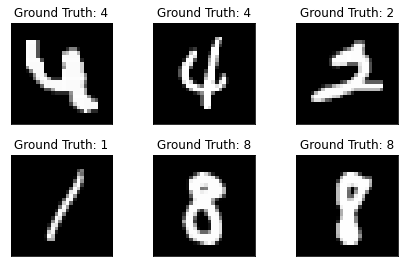

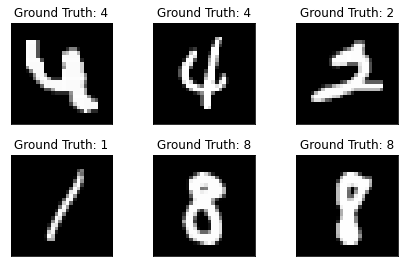

In [11]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(np.reshape(example_data[i], (28,28)), cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [12]:
model = Perceiver(
    input_channels = 1,          # number of channels for each token of the input
    input_axis = 2,              # number of axis for input data (2 for images, 3 for video)
    num_freq_bands = 4,          # number of freq bands, with original value (2 * K + 1)
    max_freq = 5.,              # maximum frequency, hyperparameter depending on how fine the data is
    depth = 2,                   # depth of net
    num_latents = 32,           # number of latents, or induced set points, or centroids. different papers giving it different names
    # cross_dim = 32,             # cross attention dimension
    latent_dim = 32,            # latent dimension
    cross_heads = 1,             # number of heads for cross attention. paper said 1
    latent_heads = 4,            # number of heads for latent self attention, 8
    cross_dim_head = 32,
    latent_dim_head = 32,
    num_classes = 10,          # ten handwritten digits
    attn_dropout = 0.5,
    ff_dropout = 0.5,
    fnet = config.fnet, # whether to replace latent transformers with FNets
    weight_tie_layers = True    # whether to weight tie layers (optional, as indicated in the diagram)
)

In [13]:
criterion = torch.nn.CrossEntropyLoss().cuda() # torch.nn.NLLLoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, amsgrad=True)

# optimizer = optim.SGD(network.parameters(), lr=config.learning_rate,
#                       config.momentum=momentum)

In [14]:
wandb.watch(model)
model.cuda()
model.train()

Perceiver(
  (layers): ModuleList(
    (0): ModuleList(
      (0): PreNorm(
        (fn): Attention(
          (to_q): Linear(in_features=32, out_features=32, bias=False)
          (to_kv): Linear(in_features=19, out_features=64, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=32, out_features=32, bias=True)
            (1): Dropout(p=0.5, inplace=False)
          )
        )
        (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm_context): LayerNorm((19,), eps=1e-05, elementwise_affine=True)
      )
      (1): PreNorm(
        (fn): FeedForward(
          (net): Sequential(
            (0): Linear(in_features=32, out_features=256, bias=True)
            (1): GEGLU()
            (2): Dropout(p=0.5, inplace=False)
            (3): Linear(in_features=128, out_features=32, bias=True)
          )
        )
        (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      )
      (2): ModuleList(
        (0): ModuleList(
  

In [15]:
def train(epoch):
  model.train()
  running_loss = 0.0
  for batch_idx, (data, target) in enumerate(train_loader):

    data = torch.as_tensor(data, dtype=torch.float32).cuda()
    target = torch.as_tensor(target, dtype=torch.long).cuda() 

    optimizer.zero_grad()
    output = model(data)

    loss = criterion(output, target)             
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if batch_idx % 20 == 19:    # print every 2000 mini-batches
        wandb.log({'loss': running_loss / 20})
        print('[%d, %6d] loss: %.6f' %
              (epoch, batch_idx + 1, running_loss / 20))
      
        running_loss = 0.0

In [16]:
def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = torch.as_tensor(data, dtype=torch.float32).cuda()
      target = torch.as_tensor(target, dtype=torch.long).cuda()
      output = model(data)
      test_loss += criterion(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()

  test_loss /= len(test_loader.dataset)
  wandb.log({'val_loss':test_loss})
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [17]:
test()
for epoch in range(1, config.epochs + 1):
  train(epoch)
  test()


Test set: Avg. loss: 0.0024, Accuracy: 1056/10000 (11%)

[1,     20] loss: 2.386205
[1,     40] loss: 2.040015
[1,     60] loss: 1.915435
[1,     80] loss: 1.795641
[1,    100] loss: 1.589226
[1,    120] loss: 1.540675
[1,    140] loss: 1.486561
[1,    160] loss: 1.405210
[1,    180] loss: 1.460581
[1,    200] loss: 1.388378
[1,    220] loss: 1.360782
[1,    240] loss: 1.274061
[1,    260] loss: 1.285263
[1,    280] loss: 1.243933
[1,    300] loss: 1.162984
[1,    320] loss: 1.233215
[1,    340] loss: 1.169502
[1,    360] loss: 1.091437
[1,    380] loss: 1.002233
[1,    400] loss: 1.040207
[1,    420] loss: 0.985524
[1,    440] loss: 1.041772
[1,    460] loss: 1.070138
[1,    480] loss: 1.015221
[1,    500] loss: 0.994819
[1,    520] loss: 0.953581
[1,    540] loss: 1.031393
[1,    560] loss: 0.975711
[1,    580] loss: 1.070727
[1,    600] loss: 1.105258
[1,    620] loss: 0.994192
[1,    640] loss: 0.991174
[1,    660] loss: 0.973299
[1,    680] loss: 0.955618
[1,    700] loss: 0.8943

In [18]:
with torch.no_grad():
  output = model(example_data)

In [ ]:
output

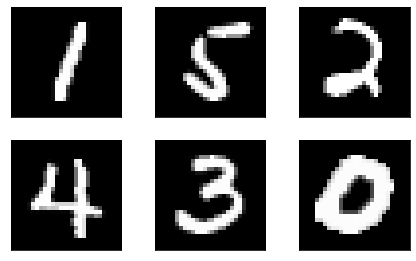

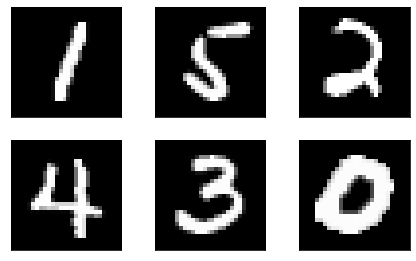

In [61]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig